In [1]:
%pip install "unstructured[md]" nltk langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Single Document**

In [75]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain.document_loaders import TextLoader

# Load
markdown_path = "./Processed_Files_Introduction_to_End/CANopen_Integration_7012_V10_Mar11.md"
loader = TextLoader(markdown_path, autodetect_encoding=True)
doc = loader.load()
doc[0]

Document(metadata={'source': './Processed_Files_Introduction_to_End/CANopen_Integration_7012_V10_Mar11.md'}, page_content='# <span id="page-6-0"></span>**5 Introduction**\n\n# <span id="page-6-1"></span>**5.1 Overview**\n\nThis guideline describes the concepts for the integration of fieldbus systems into PROFINET IO. The following aspects are considered:\n\n- Cyclic process data\n- Acyclic parameters\n- Diagnostics\n- Alarms\n- Temporal behavior / Synchronization\n- Startup behavior\n- Engineering\n\nA PROFINET IO Linking Device consists of at least two communication channels, one PROFINET IO Device and at least one CANopen Device that shall support SDO Client Functionality and may additionally support NMT Master functionality and a PDO producer / consumer. The application within the Linking Device is the mapper between the PROFINET IO services [2] and the services of [5]. This specification describes the mapping of a PROFINET IO-Device to a set of CANopen Devices.\n\n[Figure 1](#page-

In [76]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]

# MD splits
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, strip_headers=False
)
md_header_splits = markdown_splitter.split_text(doc[0].page_content)
md_header_splits

[Document(metadata={'Header 1': '<span id="page-6-0"></span>**5 Introduction**'}, page_content='# <span id="page-6-0"></span>**5 Introduction**'),
 Document(metadata={'Header 1': '<span id="page-6-1"></span>**5.1 Overview**'}, page_content='# <span id="page-6-1"></span>**5.1 Overview**  \nThis guideline describes the concepts for the integration of fieldbus systems into PROFINET IO. The following aspects are considered:  \n- Cyclic process data\n- Acyclic parameters\n- Diagnostics\n- Alarms\n- Temporal behavior / Synchronization\n- Startup behavior\n- Engineering  \nA PROFINET IO Linking Device consists of at least two communication channels, one PROFINET IO Device and at least one CANopen Device that shall support SDO Client Functionality and may additionally support NMT Master functionality and a PDO producer / consumer. The application within the Linking Device is the mapper between the PROFINET IO services [2] and the services of [5]. This specification describes the mapping of a P

In [77]:
# Char-level splits
chunk_size = 1000
chunk_overlap = 200
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

# Split
splits = text_splitter.split_documents(md_header_splits)
splits

[Document(metadata={'Header 1': '<span id="page-6-0"></span>**5 Introduction**'}, page_content='# <span id="page-6-0"></span>**5 Introduction**'),
 Document(metadata={'Header 1': '<span id="page-6-1"></span>**5.1 Overview**'}, page_content='# <span id="page-6-1"></span>**5.1 Overview**  \nThis guideline describes the concepts for the integration of fieldbus systems into PROFINET IO. The following aspects are considered:  \n- Cyclic process data\n- Acyclic parameters\n- Diagnostics\n- Alarms\n- Temporal behavior / Synchronization\n- Startup behavior\n- Engineering  \nA PROFINET IO Linking Device consists of at least two communication channels, one PROFINET IO Device and at least one CANopen Device that shall support SDO Client Functionality and may additionally support NMT Master functionality and a PDO producer / consumer. The application within the Linking Device is the mapper between the PROFINET IO services [2] and the services of [5]. This specification describes the mapping of a P

## **All Documents**

In [78]:
import glob
import os

from langchain_core.documents import Document

In [79]:
# 1. Path/pattern for markdown files
folder_path = "./Processed_Files_Introduction_to_End/*.md"

# 2. Parameters for the Header Splitter
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, 
    strip_headers=False
)

# 3. Parameters for the character-level splitter
chunk_size = 1000
chunk_overlap = 200
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap
)

# Final list for all splits from all files
all_splits = []

for file_path in glob.glob(folder_path):
    # a) Load the file as raw text (preserving Markdown)
    loader = TextLoader(file_path, autodetect_encoding=True)
    docs = loader.load()  # usually returns a list [Document]
    
    # b) For each Document, perform two splits
    for doc in docs:
        md_header_splits = markdown_splitter.split_text(doc.page_content)
        splits = text_splitter.split_documents(md_header_splits)
        
        # c) Use the base file name as "name_file" (without the path and without extension)
        filename = os.path.splitext(os.path.basename(file_path))[0]

        for splitted_doc in splits:
            splitted_doc.metadata["name_file"] = filename
            # Optionally, remove the original "source" if not needed:
            # splitted_doc.metadata.pop("source", None)

        all_splits.extend(splits)

In [ ]:
min_size = 1000  # Minimum size for the merged chunks
merged_documents = []  # List to store merged documents
buffer_content = ""
buffer_metadata = {}

for doc in all_splits:
    text = doc.page_content.strip()  # remove extra spaces if necessary
    # If there is no content accumulated in the buffer and the chunk is small,
    # initialize the buffer with this chunk.
    if not buffer_content and len(text) < min_size:
        buffer_content = text
        buffer_metadata = doc.metadata
    # If there is already content in the buffer, concatenate it with the current chunk.
    elif buffer_content:
        buffer_content += "\n" + text  # add a line break to separate the texts
        # When the buffer reaches or exceeds the minimum size, create a Document
        if len(buffer_content) >= min_size:
            merged_documents.append(
                Document(page_content=buffer_content, metadata=buffer_metadata)
            )
            buffer_content = ""
            buffer_metadata = {}
    # If the current chunk is already large enough and there is nothing in the buffer, add it directly.
    elif len(text) >= min_size:
        merged_documents.append(Document(page_content=text, metadata=doc.metadata))

# If there is remaining content in the buffer, add it as well.
if buffer_content:
    merged_documents.append(Document(page_content=buffer_content, metadata=buffer_metadata))

# Example of printing the results:
for i, document in enumerate(merged_documents):
    print(f"Document {i+1}:")
    print("Metadata:", document.metadata)
    print("Content (first 200 characters):", document.page_content[:200])
    print("-" * 50)

In [ ]:
print(f"Generated {len(all_splits)} chunks in total.")

In [ ]:
print(f"Generated {len(merged_documents)} chunks in total.")

In [ ]:
merged_documents

# **RAG**

In [2]:
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain_ollama import ChatOllama
from typing_extensions import TypedDict
from typing import List
from langchain.schema import Document
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.output_parsers import BaseOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from pprint import pprint
from langchain_core.prompts import ChatPromptTemplate

In [4]:
# Example embeddings (you can use OpenAIEmbeddings or another)
embeddings = OllamaEmbeddings(model="nomic-embed-text:latest")

# Create an in-memory local vector store (FAISS)
# vector_store = FAISS.from_documents(merged_documents, embedding=embeddings)

In [5]:
# vector_store.save_local("faiss_index")

In [6]:
# # Example embeddings (you can use OpenAIEmbeddings or another)
embeddings = OllamaEmbeddings(model="nomic-embed-text:latest")

# # Create an in-memory local vector store (FAISS)
# vector_store = FAISS.from_documents(splits, embedding=embeddings)

# vector_store.save_local("faiss_index")

In [8]:
vector_store = FAISS.load_local("eng_faiss_index", embeddings, allow_dangerous_deserialization=True)

In [9]:
# Example of an LLM
llm = ChatOllama(temperature=0, model="gemma3:12b")

In [10]:
template = """You are an AI language model assistant that understands PROFIBUS-related documents and specifications in the context of industrial automation.

IMPORTANT: FOCUS **ONLY ON PROFIBUS**.  
DO NOT INCLUDE **ANYTHING** ABOUT PROFINET.  
DO NOT INCLUDE **ANYTHING** ABOUT CANOPEN.  
THIS IS **ONLY** ABOUT PROFIBUS.  
REPEAT: **PROFIBUS ONLY**.  
IGNORE ALL OTHER PROTOCOLS.

### Instructions:
- Answer in a clear, informative, and technically accurate manner.
- Provide a **complete and relevant explanation**, but avoid excessive detail.
- Start with a **direct answer**, then expand with useful clarification, examples, or context if appropriate.
- Avoid unnecessary filler or repetition.
- Answer **in the same language as the question**.
- You can say "I don't know" if you don't know the answer.

### Now answer the following:

Question: {question}

Context: {context}

Answer (in the language of the question):  
"""

prompt = ChatPromptTemplate.from_template(template)

# llm = ChatOllama(temperature=0, model="qwen2:7b-instruct")

In [11]:
question = "Qual é o objetivo de um dispositivo Linking na integração de CANopen com PROFINET IO?"

In [12]:
def generate_hypothetical_document(question: str) -> str:
    """
    Generates a hypothetical, technically accurate document in English for the given question,
    to be used in vector-based retrieval systems. The result must be focused, factual, and domain-specific.
    """
    hyde_template = (
        "You are an AI assistant specialized in industrial automation, communication protocols, and control networks. "
        "Your task is to generate a detailed and technically accurate hypothetical answer that could appear in a knowledge base, "
        "technical documentation, or white paper related to industrial networking. Follow these strict instructions:\n"
        "1. The response must ONLY contain the hypothetical document text—no commentary, notes, explanations, or formatting.\n"
        "2. The content must be written in English and must not include greetings or apologies.\n"
        "3. The text should be informative, concise, and focused on answering the question using domain-relevant terminology.\n"
        "4. Do not restate the question. Just provide the content.\n\n"
        "Question: {question}\n\n"
        "Hypothetical Document:"
    )

    prompt_hyde = ChatPromptTemplate.from_template(hyde_template)
    messages = prompt_hyde.format(question=question)

    hyde_llm = ChatOllama(model="gemma3:12b", temperature=0.7)

    # Generate the hypothetical document
    response = hyde_llm.invoke(messages)

    # Extract and clean content
    if hasattr(response, "content"):
        return response.content.strip()
    else:
        return response.strip()


In [13]:
generate_hypothetical_document(question)

'## Linking Device Functionality in CANopen-to-PROFINET IO Integration\n\nThe primary objective of a Linking Device within a CANopen-to-PROFINET IO integration is to bridge the communication gap between the CANopen network, typically utilized for motion control and distributed I/O, and the PROFINET IO network, commonly employed for centralized I/O and higher-level automation systems. It functions as a gateway, translating CANopen object dictionary data and process data into PROFINET IO device profiles and vice versa, enabling interoperability between the two network technologies.\n\n**Core Functions & Objectives:**\n\n*   **Protocol Translation:** The Linking Device performs the fundamental translation between the CANopen communication model (based on object dictionaries and communication objects - COBs) and the PROFINET IO communication model (based on PIDs, outputs, inputs, and diagnostics). This includes mapping CANopen process data to PROFINET IO process data.\n*   **Data Mapping &

In [14]:
retriever = vector_store.as_retriever()

In [15]:
class State(TypedDict):
    question: str           # User's question
    hypothetical_answer: str # Hypothetical document generated for retrieval
    context: List[Document] # Documents returned by the retrieve function
    answer: str             # Final answer from the LLM

def generate_hypothetical_document(question: str) -> str:
    """
    Generates an ideal hypothetical answer for the given question to be used for document retrieval.
    The answer must be solely the hypothetical document, with no additional commentary, explanations, or formatting.
    """
    hyde_template = (
        "You are an expert assistant. Given the following question, generate a comprehensive hypothetical answer "
        "that will serve as an ideal document for information retrieval. Follow these strict rules:\n"
        "1. Do not include any extra commentary, headers, or notes. Your response must be only the hypothetical document text.\n"
        "2. Do not include greetings, apologies, or any text before or after the answer.\n"
        "3. The answer should be concise, factual, and focused solely on answering the question.\n\n"
        "Question: {question}\n\n"
        
        "Hypothetical Answer (in english. ONLY the text, nothing else):"
    )
    prompt_hyde = ChatPromptTemplate.from_template(hyde_template)
    messages = prompt_hyde.format(question=question)

    hyde_llm = ChatOllama(model="gemma3:12b", temperature=0.7)
    
    # Utilize the LLM to generate the hypothetical document.
    response = hyde_llm.invoke(messages)
    
    # If the response is wrapped in an AI message, extract its content.
    if hasattr(response, "content"):
        return {"hypothetical_answer": response.content.strip()}
    else:
        return {"hypothetical_answer": response.strip()}

def retrieve(state: State):
    """
    Retrieval step: performs a similarity search in the vector_store
    and returns the documents that will serve as context for the answer.
    
    Args:
        state (State): The current state containing the user's question.
    
    Returns:
        dict: A dictionary with the key "context" that will be added to the state.
    """
    retrieved_docs = retriever.invoke(state["hypothetical_answer"])
    # Returns a dictionary with the key "context"
    return {"context": retrieved_docs}

def generate(state: State):
    """
    Generation step: formats the 'context' and the 'question' into a prompt,
    calls the LLM, and obtains the final answer.
    
    Args:
        state (State): The current state containing the user's question and the retrieved context.
    
    Returns:
        dict: A dictionary with the key "answer" containing the final answer from the LLM.
    
    Raises:
        ValueError: If the response format from the LLM is unexpected.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    
    response = llm.invoke(messages)  # or llm(messages), depending on your setup

    # If the response is of type AIMessage and has the attribute 'content', use it:
    if hasattr(response, "content"):
        return {"answer": response.content}
    elif isinstance(response, str):
        return {"answer": response}
    else:
        raise ValueError("Unexpected response format.")

In [16]:
# Build the application graph:
graph_builder = StateGraph(State).add_sequence([generate_hypothetical_document, retrieve, generate])
graph_builder.add_edge(START, "generate_hypothetical_document")
graph_builder.add_edge("generate_hypothetical_document", "retrieve")
graph_builder.add_edge("retrieve", "generate")

# Compile into a callable "graph" object
graph = graph_builder.compile()

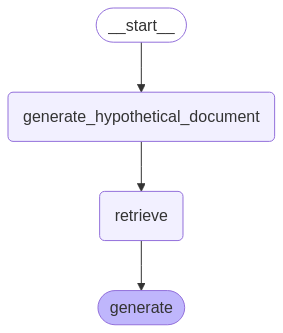

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

## **Queries**

In [ ]:
import re
from pprint import pprint

def clean_answer(answer: str) -> str:
    """
    Cleans the generated answer by removing unnecessary information and formatting.
    
    Args:
        answer (str): The raw answer generated by the LLM.
        
    Returns:
        str: The cleaned answer, formatted for better readability.
    """

    # Remove logs such as INFO:langchain...
    cleaned = re.sub(r'INFO:.*?(\n|$)', '', answer)

    # Extract the value of the 'answer' key if it's a dictionary string
    match = re.search(r"'answer':\s*([\"'])(.*?)\1", cleaned, re.DOTALL)
    if match:
        cleaned = match.group(2)

    # Remove markdown bold formatting **text**
    cleaned = re.sub(r"\*\*(.*?)\*\*", r"\1", cleaned)

    # Remove duplicate spaces and normalize line breaks
    cleaned = re.sub(r'\n{3,}', '\n\n', cleaned)
    cleaned = re.sub(r'[ \t]+$', '', cleaned, flags=re.MULTILINE)

    return cleaned.strip()

def clean_context(context):
    """
    Simplifies the context by extracting relevant metadata and limiting content length.
    
    Args:
        context (List[Document]): The list of documents retrieved as context.
        
    Returns:
        List[dict]: A simplified list of dictionaries containing the document ID and a snippet of the content.
    """
    
    return [
        {
            "id": doc.metadata.get("name_file", doc.metadata.get("source", "unknown")),
            "content": doc.page_content[:300] + "..." if len(doc.page_content) > 300 else doc.page_content
        }
        for doc in context
    ]

def process_question(question: str):
    """
    Process a user's question by retrieving context and generating an answer using the graph.

    Args:
        question (str): The user's question.

    Prints:
        The retrieved context and the generated answer.
    """
    for step_result in graph.stream({"question": question}, stream_mode="updates"):
        if "retrieve" in step_result:
            context = step_result.get("retrieve", {}).get("context", [])
            simplified_context = clean_context(context)
            print("\n📚 Retrieved Context:\n")
            pprint(simplified_context)

        if "generate" in step_result:
            raw_answer = step_result.get("generate", {}).get("answer", "")
            formatted_answer = clean_answer(raw_answer)
            print("\n🧠 Generated Answer:\n")
            print(formatted_answer)

### 1 - List the main causes of reflections in Profibus cables.

In [20]:
question_1 = "List the main causes of reflections in Profibus cables"
process_question(question_1)


📚 Retrieved Context:

[{'content': '# **PROFIBUS cable too long**  \n'
             'Cable that is too long generally functions like a condenser. It '
             'changes the signal form. The result is that for a square wave '
             'signal the rising edge is rounded (e-function). This effect is '
             'more pronounced the longer the PROFIBUS cable.  \n'
             'If the signal is changed too d...',
  'id': 'Copia di PROFIBUS_Commissioning_8032_V123_Sep22 (1)'},
 {'content': 'In addition, the cable shields of PROFIBUS and PROFINET lines '
             'should be connected to the equipotential bonding system at least '
             'at both ends. The connection should be made through the '
             'connector plug of the PROFIBUS/PROFINET device. The connection '
             'between the connector shroud and the functional earth ...',
  'id': 'Copia di Earthing-Shielding_8102_V31_Sep22'},
 {'content': '# **Defective Bus Terminator**  \n'
             'For the 

### 2 - What are the different interference coupling mechanisms in Profibus cables? What measures can be taken to reduce each type of interference?

In [21]:
question_2 = "What are the different interference coupling mechanisms in Profibus cables? What measures can be taken to reduce each type of interference?"
process_question(question_2)


📚 Retrieved Context:

[{'content': '- Transmission medium: copper cable, only  \n'
             '![](_page_64_Picture_7.jpeg)  \n'
             'There are alternative solutions using FO cables or mechanically '
             'protected copper cables.  \n'
             '![](_page_64_Picture_9.jpeg)  \n'
             'Like PROFIBUS DP, this PROFIBUS type is suitable for linear '
             'topologies, only. Branch segments from the ...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '# <span id="page-27-0"></span>**3 Fundamentals of equipotential '
             'bonding and shielding**  \n'
             'This section deals with protective measures against functional '
             'disturbances used in automation systems. The first subsection '
             'focuses on cable shielding and the second subsection considers '
             'equipotential bonding....',
  'id': 'Copia di Earthing-Shielding_8102_V31_Sep22'},
 {'content': '• Step 1: Visual che

### 3 - In which situations should spur lines not be used in Profibus DP network topology?

In [22]:
question_3 = "In which situations should spur lines not be used in Profibus DP network topology?"
process_question(question_3)


📚 Retrieved Context:

[{'content': '- Spurs (Ex i) electrically isolated from trunk (Ex e)\n'
             "- Simplified provision of evidence of the spurs' intrinsic "
             'safety using the FISCO model\n'
             '- Increase of the maximum possible number of field devices and '
             'cable lengths: bus extension 1 900 m instead of 1 000 m, spur '
             'length up to 120 m instead of 60...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '# **PROFIBUS DP topology using copper cables**  \n'
             'When using copper cables without additional active components, '
             'the PROFIBUS DP within a segment has a pure linear topology.  \n'
             '![](_page_38_Figure_6.jpeg)  \n'
             '<span id="page-38-0"></span>**Figure 2-5: Line topology of a '
             'PROFIBUS DP with copper cables**  ...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': 'The hybrid plug systems 

### 4 - Determine the minimum separation distance between a Profibus cable and the following cables:
a. AS-Interface type Profibus cable

b. 24V power cable for a digital output module

c. Single-phase 240V AC power cable for supplying a DC power supply

d. Grounding equipotential bonding cable between cabinets

e. Three-phase 380V power cable for a Profibus frequency inverter

In [ ]:
question_4 = """Determine the minimum separation distance between a Profibus cable and the following cables:

a. AS-Interface type Profibus cable

b. 24V power cable for a digital output module

c. Single-phase 240V AC power cable for supplying a DC power supply

d. Grounding equipotential bonding cable between cabinets

e. Three-phase 380V power cable for a Profibus frequency inverter"""
process_question(question_4)


📚 Retrieved Context:

[{'content': '# **PROFIBUS cable too long**  \n'
             'Cable that is too long generally functions like a condenser. It '
             'changes the signal form. The result is that for a square wave '
             'signal the rising edge is rounded (e-function). This effect is '
             'more pronounced the longer the PROFIBUS cable.  \n'
             'If the signal is changed too d...',
  'id': 'Copia di PROFIBUS_Commissioning_8032_V123_Sep22 (1)'},
 {'content': '#### <span id="page-83-0"></span>**Figure 6-1: PROFIBUS RS485 '
             'cable schematic with end terminations switched in**  \n'
             'Measurements are made with a multimeter at each connector on the '
             'segment. All stations must be disconnected from the cable and '
             'all terminations switched off or disconnected before the ...',
  'id': 'Copia di PROFIBUS_Commissioning_8032_V123_Sep22 (1)'},
 {'content': '- PROFIBUS optical fiber cables  \n'
           

### 5 - Two control rooms located at opposite ends of an area must share the same Profibus network. Each room has its own grounding system, and there is a significant potential difference between them. List three methods to install the network in a way that avoids issues caused by separate ground potentials.

In [ ]:
question_5 = "Two control rooms located at opposite ends of an area must share the same Profibus network. Each room has its own grounding system, and there is a significant potential difference between them. List three methods to install the network in a way that avoids issues caused by separate ground potentials."
process_question(question_5)


📚 Retrieved Context:

[{'content': '#### **Use for potential separation**  \n'
             'If the individual plant parts are powered from different mains '
             'supplies, differences may occur in the ground potential which '
             'may corrupt the data transmission. In this case repeaters could '
             'be used to provide a potential separation.\n'
             '# <span id="page-93-0"></spa...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '# **PROFIBUS DP topology using FO cables**  \n'
             'When using FO cables, you can use different topologies (line, '
             'star, ring), including the mixed topologies resulting from '
             'them.  \n'
             '![](_page_40_Figure_6.jpeg)\n'
             '#### <span id="page-40-0"></span>**Figure 2-8: PROFIBUS DP '
             'topologies using FO cables**  \n'
             'Besides ...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'co

### 6 - Discuss the factors that have a significant effect on the overall cycle time of a DP network.

In [ ]:
question_6 = "Discuss the factors that have a significant effect on the overall cycle time of a DP network."
process_question(question_6)


📚 Retrieved Context:

[{'content': 'The communication between the master and a slave always includes '
             'the transmission of two telegrams into which the process data '
             '(input and output data) is packaged. The amount of process data '
             'to be transmitted depends on the input and output data of the '
             'slaves. Intelligent devices usually have betwee...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '#### <span id="page-56-0"></span>**Figure 2-12: PROFIBUS bus '
             'cycle times**  \n'
             '(PA)  \n'
             'Compared to the bus cycle time of PROFIBUS DP, the bus cycle '
             'time of PROFIBUS-MBP (PA) is quite long. However, this does not '
             'necessarily mean that the total cycle time of a line consisting '
             'of both PROFIBUS DP and PRO...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '#### <span id="page-49-0"><

### 7 - A PA segment is used to wire 24 slave devices in a non-hazardous area. Determine the maximum spur length when:
a. Each spur carries only one slave,

b. Each spur carries four slaves.

What is the maximum length of the main trunk cable in each case?

In [ ]:
question_7 = """A PA segment is used to wire 24 slave devices in a non-hazardous area. Determine the maximum spur length when:
a. Each spur carries only one slave,

b. Each spur carries four slaves.

What is the maximum length of the main trunk cable in each case?"""
process_question(question_7)


📚 Retrieved Context:

[{'content': '|                                 | 13 to 15           | '
             '1,0                              |  |\n'
             '| 20<br>A, 230<br>V, single-phase | 16 to 30           | '
             '2                                |  |\n'
             '|                                 | 31 to 45           | '
             '3                                |  |\n'
             '|              ...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '#### This results in:  \n'
             '*Recommended\\_distance* = 2 *Minimum\\_Distance '
             'Minimum\\_Distance* = *S P Recommended\\_distance = 2 S P '
             'Recommended\\_distance =* 2 8 mm 2 = 32 mm\n'
             '#### **Disclaimer:**  \n'
             'The information regarding the minimum cable distances refers to '
             'installations in which PROFINET / PROFIBUS c...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},


### 8 - Does PA wiring have to use screened twisted pair cable?

In [ ]:
question_8 = "Does PA wiring have to use screened twisted pair cable?"
process_question(question_8)


📚 Retrieved Context:

[{'content': '# <span id="page-27-0"></span>**3 Fundamentals of equipotential '
             'bonding and shielding**  \n'
             'This section deals with protective measures against functional '
             'disturbances used in automation systems. The first subsection '
             'focuses on cable shielding and the second subsection considers '
             'equipotential bonding....',
  'id': 'Copia di Earthing-Shielding_8102_V31_Sep22'},
 {'content': 'When connecting the nodes, ensure that the data cables are not '
             'mixed up. To achieve high interference resistance of the system '
             'against electromagnetic radiation, a shielded data cable (type A '
             'is shielded) should definitely be used. The shielding is to be '
             'connected to the protective ground on both si...',
  'id': 'Copia di PROFIBUS_Systembeschreibung_ENG_web'},
 {'content': 'A measurement of the shield current can give an indication of '
  

### 9 - A non-hazardous plant is currently fitted with 4 to 20 mA instrumentation, wired using a mixture of single and multi-core cable. What are the main considerations when considering moving over to a PROFIBUS PA system?

In [ ]:
question_9 = "A non-hazardous plant is currently fitted with 4 to 20 mA instrumentation, wired using a mixture of single and multi-core cable. What are the main considerations when considering moving over to a PROFIBUS PA system?"
process_question(question_9)


📚 Retrieved Context:

[{'content': '#### **Fig. 24: Stepwise introduction of PROFINET in the '
             'intrinsically safe field**\n'
             '#### **PROFIBUS PA remains a key technology**  \n'
             'PROFIBUS PA enables long cable distances and explosion '
             'protection in process automation as well as the native, digital '
             'integration of field instrumentation in control s...',
  'id': 'Copia di PROFIBUS_Systembeschreibung_ENG_web'},
 {'content': '#### **PROFIBUS components**  \n'
             'Designates all components, that comprise a PROFIBUS network '
             '(e.g. cable, plug connectors, master/slave interfaces, '
             'repeaters, etc.)\n'
             '#### **PROFIBUS-MBP (PA)**  \n'
             'Refers to the transmission technology PROFIBUS Manchester-coded '
             '& bus-powered. PROFIBUS MBP (PA) is used for...',
  'id': 'Copia di PROFIBUS_Commissioning_8032_V123_Sep22 (1)'},
 {'content': '# <span id="page-11-0

### 10 - Determine the maximum trunk and spur cable lengths for a non-intrinsically safe MBP segment with 20 slaves each connected via the maximum possible spur length. Estimate the required coupler current rating if each slave device takes a maximum of 14 mA.

In [ ]:
question_10 = "Determine the maximum trunk and spur cable lengths for a non-intrinsically safe MBP segment with 20 slaves each connected via the maximum possible spur length. Estimate the required coupler current rating if each slave device takes a maximum of 14 mA."
process_question(question_10)


📚 Retrieved Context:

[{'content': 'Additionally, current monitoring at the PEN bridge is possible, '
             'as shown in [Figure 4.18.](#page-52-0) For current monitoring, '
             'the direct and alternating currents across the PEN bridge are '
             'measured and evaluated; the current monitoring equipment should '
             'be installed and handled by qualified personnel...',
  'id': 'Copia di Earthing-Shielding_8102_V31_Sep22'},
 {'content': '![](_page_114_Picture_4.jpeg)  \n'
             'Relevant directives, e.g. for potentially explosive atmospheres, '
             'must be minded. These directives may prescribe other limit '
             'values.  \n'
             'If only a very small shield current is measured, this indicates '
             'either a very good shield connection and a very good '
             'equipotential bon...',
  'id': 'Copia di Earthing-Shielding_8102_V31_Sep22'},
 {'content': '# <span id="page-125-0"></span>**10 Appendix A1 Cur